## Load configs and read data

In [51]:
from nltk.corpus import stopwords   
from stop_words import safe_get_stop_words
import numpy as np  
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import ujson

In [52]:
mapping = ujson.load(open('config.json','r'))

In [53]:
LANG = 'ua'
LOSS = 'custom'

In [80]:
data = pd.read_csv(mapping[LANG]['dataset_file'],
                   nrows=mapping[LANG]['dataset_size'])

## Cleaned texts and summaries analysis

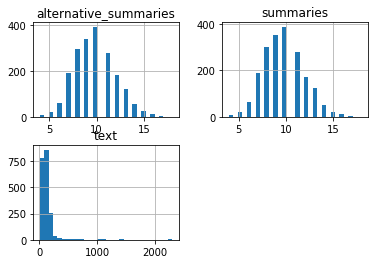

In [81]:
import matplotlib.pyplot as plt
text_word_count = []
summaries_word_count = []
alternative_summaries_word_count = []

for i in data[f'cleaned_{mapping[LANG]["text_column"]}']:
      text_word_count.append(len(i.split()))

for i in data[f'cleaned_{mapping[LANG]["summaries_column"]}']:
      summaries_word_count.append(len(i.split()))
        
for i in data[f'cleaned_alternative_{mapping[LANG]["summaries_column"]}']:
      alternative_summaries_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count,
                          'summaries':summaries_word_count,
                          'alternative_summaries':alternative_summaries_word_count})
length_df.hist(bins = 30)
plt.show()

In [82]:
max_len_text=200 
max_len_summaries=15

In [83]:
valid_train_samples_fraction = length_df[(length_df['text'] <= max_len_text)\
                                         &(length_df['summaries'] <= max_len_summaries)\
                                         &(length_df['alternative_summaries'] <= max_len_summaries)].shape[0] / data.shape[0]
valid_train_samples_fraction

0.893

## Split dataset, prepare tokenizers, pad sequences

In [84]:
if LOSS == 'custom':
    label_cols = [f'cleaned_{mapping[LANG]["summaries_column"]}',f'cleaned_alternative_{mapping[LANG]["summaries_column"]}']
else:
    label_cols = f'cleaned_{mapping[LANG]["summaries_column"]}'

In [85]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data[f'cleaned_{mapping[LANG]["text_column"]}'],
                                            data[label_cols],
                                            test_size=0.1,
                                            random_state=0,
                                            shuffle=True)

In [86]:
y_val

cleaned_title  \
405   _START_ росія готується до активізації бойових...   
1190  _START_ шевченко грі хорватією планує застосув...   
1132  _START_ активісти заблокували відділення сберб...   
731   _START_ рада директорів схвалила банкрутство а...   
1754  _START_ москва давно шукала привід для захопле...   
...                                                 ...   
1363  _START_ сбу заборонила їзд до україни російськ...   
1981  _START_ сбербанк запровадив нові ліміти на опе...   
384   _START_ на карнавалі під парижем стався вибух ...   
1158  _START_ від вибухів на арсеналі балаклії загин...   
1604  _START_ молдова виключила вино переліку алкого...   

                              cleaned_alternative_title  
405   _START_ росія готується до активізації бойових...  
1190  _START_ шевченко грі хорватією планує застосув...  
1132  _START_ активісти заблокували відділення сберб...  
731   _START_ рада директорів схвалила банкрутство а...  
1754  _START_ москва давно шукала привід для захопле...  
...                                                 ...  
1363  _START_ дівчина на візку не їде реакція соцмер...  
1981  _START_ сбербанк запровадив нові ліміти на опе...  
384   _START_ на карнавалі під парижем стався вибух ...  
1158  _START_ під завалами будинку балаклії знайшли ...  
1604  _START_ молдова виключила вино переліку алкого...  

[200 rows x 2 columns]

In [87]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [88]:
x_tr.shape

(1800, 200)

In [89]:
x_val.shape

(200, 200)

In [90]:
y_tokenizer = Tokenizer()

if LOSS=='custom':
    #preparing a tokenizer for summary on training data 
    y_tokenizer.fit_on_texts(list(y_tr['cleaned_title'])+list(y_tr['cleaned_alternative_title']))

    #convert summary sequences into integer sequences
    y_tr['cleaned_title'] = y_tokenizer.texts_to_sequences(y_tr['cleaned_title'])
    y_tr['cleaned_alternative_title'] = y_tokenizer.texts_to_sequences(y_tr['cleaned_alternative_title'])
    y_val['cleaned_title'] = y_tokenizer.texts_to_sequences(y_val['cleaned_title'])
    y_val['cleaned_alternative_title'] = y_tokenizer.texts_to_sequences(y_val['cleaned_alternative_title'])

    #padding zero upto maximum length
    y_tr_ct = pad_sequences(y_tr['cleaned_title'], maxlen=max_len_summaries, padding='post')
    y_tr_cat = pad_sequences(y_tr['cleaned_alternative_title'], maxlen=max_len_summaries, padding='post')
    y_val_ct = pad_sequences(y_val['cleaned_title'], maxlen=max_len_summaries, padding='post')
    y_val_cat = pad_sequences(y_val['cleaned_alternative_title'], maxlen=max_len_summaries, padding='post')

    y_tr['cleaned_title'] = pd.Series([y_tr_ct[index,:] for index in range(y_tr_ct.shape[0])], index=y_tr.index)
    y_tr['cleaned_alternative_title'] = pd.Series([y_tr_cat[index,:] for index in range(y_tr_cat.shape[0])], index=y_tr.index)
    y_val['cleaned_title'] = pd.Series([y_val_ct[index,:] for index in range(y_val_ct.shape[0])], index=y_val.index)
    y_val['cleaned_alternative_title'] = pd.Series([y_val_cat[index,:] for index in range(y_val_cat.shape[0])], index=y_val.index)
    
elif LOSS=='common':
    #preparing a tokenizer for summary on training data 
    y_tokenizer.fit_on_texts(list(y_tr))

    #convert summary sequences into integer sequences
    y_tr = y_tokenizer.texts_to_sequences(y_tr)
    y_val = y_tokenizer.texts_to_sequences(y_val)

    #padding zero upto maximum length
    y_tr = pad_sequences(y_tr, maxlen=max_len_summaries, padding='post')
    y_val = pad_sequences(y_val, maxlen=max_len_summaries, padding='post')
    
y_voc_size  =   len(y_tokenizer.word_index) + 1

[[   1   43 5318 ...    0    0    0]
 [   1  419 1231 ...    0    0    0]
 [   1  567  382 ...    0    0    0]
 ...
 [   1    3   29 ...    0    0    0]
 [   1   15  168 ...    0    0    0]
 [   1 1508    2 ...    0    0    0]]
                                          cleaned_title  \
405   [1, 43, 5318, 5, 1229, 145, 35, 2, 0, 0, 0, 0,...   
1190  [1, 419, 1231, 1222, 450, 2, 0, 0, 0, 0, 0, 0,...   
1132  [1, 567, 382, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
731   [1, 47, 4631, 421, 961, 955, 2, 0, 0, 0, 0, 0,...   
1754  [1, 3126, 9, 4718, 11, 166, 24, 3852, 2, 0, 0,...   
...                                                 ...   
1363  [1, 40, 1355, 296, 5, 7, 396, 6083, 143, 2, 0,...   
1981  [1, 333, 972, 4006, 3, 1442, 11, 2, 0, 0, 0, 0...   
384   [1, 3, 29, 1603, 142, 2, 0, 0, 0, 0, 0, 0, 0, ...   
1158  [1, 15, 168, 3, 869, 22, 5674, 6122, 2, 0, 0, ...   
1604   [1, 1508, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                              cleaned_alternative_title  
405  

In [91]:
print(y_tr)
print(y_val)

                                          cleaned_title  \
1018  [1, 1118, 313, 1119, 8, 2068, 2069, 5, 393, 72...   
655   [1, 2070, 2071, 2072, 2073, 67, 2074, 2075, 2,...   
436   [1, 33, 2076, 190, 140, 4, 1021, 2077, 394, 2,...   
921   [1, 251, 667, 206, 3, 1120, 6, 519, 1121, 2, 0...   
1340  [1, 725, 726, 727, 2078, 2079, 3, 296, 668, 65...   
...                                                 ...   
835   [1, 5837, 5838, 9, 52, 135, 5839, 2, 0, 0, 0, ...   
1216  [1, 42, 1913, 1911, 723, 5840, 1746, 26, 5841,...   
1653  [1, 17, 351, 5842, 431, 5843, 5844, 583, 2, 0,...   
559   [1, 117, 5845, 30, 1905, 8, 1864, 1896, 470, 7...   
684   [1, 117, 1868, 5846, 5847, 5848, 471, 26, 2, 0...   

                              cleaned_alternative_title  
1018  [1, 1118, 313, 1119, 8, 2068, 2069, 5, 393, 72...  
655   [1, 2070, 2071, 2072, 2073, 67, 2074, 2075, 2,...  
436   [1, 33, 2076, 190, 140, 4, 1021, 2077, 394, 2,...  
921   [1, 251, 667, 206, 3, 1120, 6, 519, 1121, 2, 0...  
1

### Models

In [92]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 200 #500

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     8433000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 200), ( 320800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [93]:
def custom_loss(y_actual,y_pred):
    loss=K.sparse_categorical_crossentropy(y_actual['cleaned_title']-y_pred)
    alternative_loss=K.sparse_categorical_crossentropy(y_actual['cleaned_alternative_title']-y_pred)
    return min(loss, alternative_loss)

In [94]:
model.compile(optimizer='rmsprop',
              loss=custom_loss)

In [95]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

### Training

In [102]:
np.reshape(y_tr['cleaned_title'].values, (y_tr.shape[0],-1))

array([[array([   1,  429,  236, 1889, 4237, 1165,  935, 4238, 4239,    2,    0,
          0,    0,    0,    0], dtype=int32)],
       [array([   1, 1416,   28,   41, 3478,  628,  531,    3,   36,  303,  209,
       1674,    2,    0,    0], dtype=int32)],
       [array([   1, 1519,  251, 3041, 1520,  640, 3042,  779, 1521,    2,    0,
          0,    0,    0,    0], dtype=int32)],
       ...,
       [array([   1,  579, 5586, 1856,   27,    5,  799,  203,  135,  160,    2,
          0,    0,    0,    0], dtype=int32)],
       [array([1606, 1607,   29, 3294,    3,  981, 3295, 3296, 3297, 3298, 1608,
         19,   17, 1342,    2], dtype=int32)],
       [array([   1,  577,  264, 3538, 1700,   18, 1701,    5, 3539,    2,    0,
          0,    0,    0,    0], dtype=int32)]], dtype=object)

In [54]:
if LOSS == 'common':
    history=model.fit(x=[x_tr,y_tr[:,:-1]],
                      y=y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                      epochs=5,
                      callbacks=[es],
                      batch_size=512,
                      validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
elif LOSS == 'custom':
    history=model.fit(x=[np.vstack([x_tr, x_tr]),
                         np.vstack([y_tr['cleaned_title'][:,:-1], y_tr['cleaned_alternative_title'][:,:-1]])],
                      y=np.vstack([y_tr['cleaned_title'].reshape(y_tr.shape[0],y_tr['cleaned_title'].shape[1], 1)[:,1:],
                                   y_tr['cleaned_alternative_title'].reshape(y_tr.shape[0],y_tr['cleaned_alternative_title'].shape[1], 1)[:,1:]]),
                      epochs=5,
                      callbacks=[es],
                      batch_size=512,
                      validation_data=([np.vstack([x_val, x_val]),
                                        np.vstack([y_val['cleaned_title'][:,:-1], y_val['cleaned_alternative_title'][:,:-1]])],
                                       np.vstack([y_val['cleaned_title'].reshape(y_val.shape[0],y_val['cleaned_title'].shape[1], 1)[:,1:],
                                                  y_val['cleaned_alternative_title'].reshape(y_val.shape[0],y_val['cleaned_alternative_title'].shape[1], 1)[:,1:]])))

ValueError: Can only tuple-index with a MultiIndex

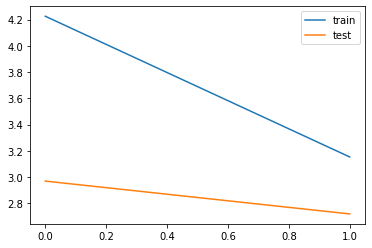

In [48]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

### Inference

In [49]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [50]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    print('e_out :', e_out)
    print('e_h :', e_h)
    print('e_c :', e_c)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        print(sampled_token)

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [68]:
for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print(x_val[i].reshape(1,max_len_text))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: energy chews absolutely delicious hold really well pocket backpack backpacking mountain biking really could imagine eating energy chew ever 
Original summary: love these energy chews 
[[ 309 1645  291   71  998   11   29 1707 5115 9342  621 8163   11   38
  1164  130  309  687   96    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
e_out : [[[ 2.7556503e-03 -3.1716540e-03 -2.6469242e-03 ... -2.8209391e-03
   -2.8331878e-03 -4.8030948e-04]
  [ 6.9534420e-03 -8.6153373e-03 -7.5831795e-03 ... -7.7757547e-03
   -7.9394272e-03 -1.1456031e-03]
  [ 1.3171098e-02 -1.7581269e-02 -1.6241960e-02 ... -1.5719535e-02
   -1.6645078e-02 -2.2875695e-03]
  ...
  [ 7.0142889e-01 -9.1824007e-01 -7.7192682e-01 ... -8.8866115e-01
   -7.8252

great
end


KeyError: 0